In [28]:
annotation_file = "harbor_annotation_0512.json"

import json
import collections
import pandas as pd
import seaborn as sns


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 500)

with open(annotation_file, 'r') as f:
    annotation_obj = json.load(f)

In [29]:
BINARY_FIELDS = 'importance originality method presentation interpretation reproducibility'.split()
LIKERT_FIELDS = "overall evidence constructiveness".split()
ALL_FIELDS = BINARY_FIELDS + LIKERT_FIELDS

METAREVIEW = "metareview"
VALID_ANNOTATORS = "AS CL DP SB".split()

class Conference(object):
    iclr = "iclr"
    #neurips = "neurips"
    ALL = [iclr, 
           #neurips
          ]
    
TEXT_FILE_MAP = {
    Conference.iclr: "iclr18_annotation_input_297.json",
    #Conference.neurips: "neurips18_annotation_input_297.json",
}


class Review(object):
    def __init__(self, json_object):
        self.review_id = json_object["review_sid"]
        self.review_text = json_object["review_text"]["text"]
        self.review_len = len(self.review_text)
    

review_map = {}

for conf, conf_file in TEXT_FILE_MAP.items():
    with open(conf_file, 'r') as f:
        conf_obj = json.load(f)
        for review_obj in conf_obj["review_rebuttal_pairs"]:
            review_map[review_obj["review_sid"]] = Review(review_obj)
            

def metareview_cleanup(key, value):
    if key == value:
        return key
    elif key.lower() == METAREVIEW:
        return value
    else:
        assert value.lower() == METAREVIEW
        return key

def clean_ratings(ratings_json, pk):
    new_ratings = {}
    for k, v in json.loads(ratings_json).items():
        try:
            int_value = int(v)
            if k in BINARY_FIELDS:
                if pk < 28:
                    int_value = int(int_value > 2)
                else:
                    assert int_value in range(2)
            new_ratings[k.lower()] = int_value
        except ValueError: # Probably metareview field
            new_ratings[METAREVIEW] = metareview_cleanup(k, v)
    return new_ratings


class Annotation(object):
    def __init__(self, django_json, review_map):
        django_fields = django_json['fields']
        self.review_id = django_fields["review_id"]
        self.annotator = django_fields["annotator_initials"]
        self.comment = django_fields["comment"]
        self.conference = "NeurIPS" if 'NIPS' in self.review_id else 'ICLR'
        self.review_length = review_map[self.review_id].review_len
        
        ratings_json = clean_ratings(django_fields["ratings"], django_json["pk"])
        
        self.ratings = {}

        for field in ALL_FIELDS:
            if field in ratings_json:
                val = ratings_json[field]
            else:
                val = None
                
            self.ratings[field] = val

    def to_dict(self):
        dict_rep = {
            "review_id": self.review_id,
            "annotator": self.annotator,
            "comment": self.comment,
            "review_length": self.review_length,
            "conference": self.conference,
            "binary_sum": sum(v for k, v in self.ratings.items() if k in BINARY_FIELDS and v is not None)
        }
        dict_rep.update(self.ratings)
        return dict_rep

In [30]:
dicts = [Annotation(i, review_map).to_dict()
         for i in annotation_obj
         if i["fields"]["annotator_initials"] in VALID_ANNOTATORS and 'NIPS' not in i["fields"]["review_id"]]
df = pd.DataFrame(dicts)

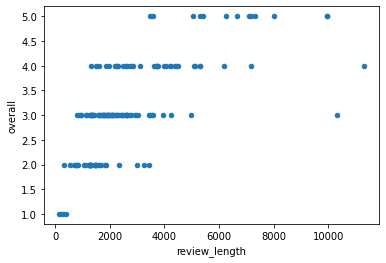

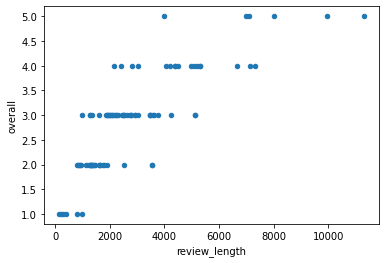

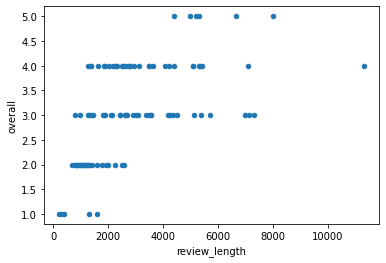

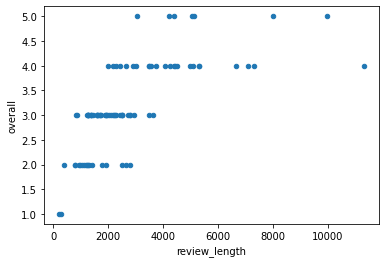

In [33]:
for annotator in VALID_ANNOTATORS:
    df[df.annotator == annotator].plot.scatter(x="review_length", y="overall")

In [48]:
anno_map = collections.defaultdict(list)

overall_binsum_counter = collections.defaultdict(lambda: collections.Counter())
for i in  df.to_dict(orient="records"):
    anno_map[i["review_id"]].append(i["annotator"])
    overall = i["overall"]
    binsum = i["binary_sum"]
    
    if overall in [1.0, 2.0, 3.0, 4.0, 5.0] and binsum in range(7):
        overall_binsum_counter[overall][binsum] += 1
        
print(overall_binsum_counter)

multiple_annotator_reviews = []
for k, v in anno_map.items():
    if len(v) > 1:
        multiple_annotator_reviews.append(k)
    
    

defaultdict(<function <lambda> at 0x12e587550>, {2.0: Counter({1: 35, 2: 32, 3: 18, 0: 6, 4: 3}), 4.0: Counter({3: 37, 4: 36, 2: 19, 5: 11, 1: 3, 6: 2}), 5.0: Counter({4: 11, 3: 9, 5: 8, 2: 3, 6: 1}), 3.0: Counter({3: 64, 2: 51, 4: 32, 1: 18, 5: 5, 0: 1}), 1.0: Counter({0: 10, 1: 6, 2: 1})})


In [43]:
# for review_id in multiple_annotator_reviews:
#     print(df[df.review_id == review_id].filter("annotator overall binary_sum".split()))
#     print()

In [66]:
overall_binsum_df = pd.DataFrame(overall_binsum_counter)
overall_binsum_df.fillna(0, inplace=True)
overall_binsum_df.sort_index(level=0, inplace=True)
overall_binsum_df = overall_binsum_df.reindex(sorted(overall_binsum_df.columns), axis=1)

[Text(0.5, 15.0, 'Overall scores'), Text(33.0, 0.5, 'Sum of binary scores')]

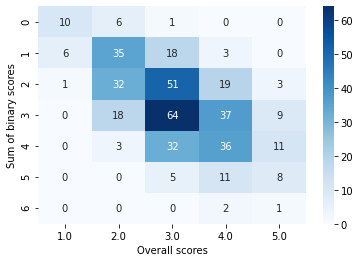

In [74]:
ax = sns.heatmap(overall_binsum_df, cmap="Blues", annot=True, fmt=".0f",)

ax.set(xlabel='Overall scores', ylabel='Sum of binary scores')

<AxesSubplot:xlabel='binary_sum', ylabel='review_length'>

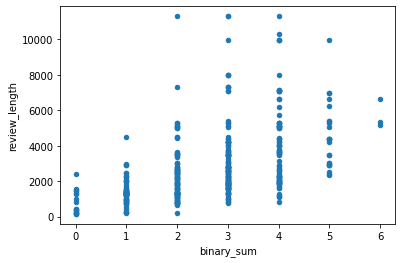

In [76]:
df.plot.scatter(x='binary_sum', y="review_length")

In [80]:
df[df["review_length"] > 10000]

,review_id,annotator,comment,review_length,conference,binary_sum,importance,originality,method,presentation,interpretation,reproducibility,overall,evidence,constructiveness
95,S1GVQk5gG,CL,,11305,ICLR,2,0.0,0.0,1.0,1,0,NaN,5.0,4,5
121,S1GVQk5gG,SB,,11305,ICLR,4,1.0,0.0,1.0,1,1,0.0,4.0,5,5
158,S1GVQk5gG,DP,,11305,ICLR,3,0.0,0.0,1.0,1,1,0.0,4.0,4,5
260,S1GVQk5gG,AS,,11305,ICLR,3,0.0,0.0,1.0,1,1,0.0,4.0,5,4
347,ByGPUUYgz,AS,"well, I'm not sure if the meta reviewer disagreed, but the ! indicates to me that they did",10306,ICLR,4,1.0,1.0,1.0,0,1,0.0,3.0,3,4
